In [1]:
import pandas as pd
import warnings


warnings.filterwarnings('ignore')
df = pd.read_csv("purchase_time_series.csv")
df.head()

,Unnamed: 0,TransactionId,CardNo,TransacionDate,ProdcutId,productname,productDescription,itemcode,ProductCategory,ProductSubCategory,quantity,SellingPrice,purchaseprice
0,0,10115,5.456510e+14,2017-03-25 22:28:48.640,5,Shirt,Shirt,se2313,Dress,Mens wear,1.0,799.00,775.03
1,1,10115,5.456510e+14,2017-03-25 22:28:48.640,6,Shorts,Shorts,sd2332,Dress,Mens wear,1.0,599.99,581.99
2,2,10115,5.456510e+14,2017-03-25 22:28:48.640,48,Rayban Women's Sunglasses,Rayban Women's Sunglasses,raywms1234,Fashion,Latest Fashions,1.0,250.00,242.50
3,3,10115,5.456510e+14,2017-03-25 22:28:48.640,47,Rayban Wayfarer Sunglasses,Rayban Wayfarer Sunglasses,rayws1234,Fashion,Latest Fashions,1.0,125.00,121.25
4,4,10115,5.456510e+14,2017-03-25 22:28:48.640,1098,Shirt,NaN,2,Gents,Common,1.0,60.00,0.00


In [2]:
import datetime as dt
df['TransacionDate'] = pd.to_datetime(df['TransacionDate']).dt.date
df = df[pd.notnull(df['CardNo'])]

In [3]:
cols_of_interest = ['CardNo', 'TransacionDate', 'SellingPrice']
df = df[cols_of_interest]

In [4]:

import csv
df=df.sort_values('TransacionDate')

print(df['CardNo'].nunique())

22006


In [22]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
data = summary_data_from_transaction_data(df, 'CardNo', 'TransacionDate', monetary_value_col='SellingPrice', observation_period_end='2018-03-12')
data.head()

,frequency,recency,T,monetary_value
CardNo,,,,
5.456688e+08,12.0,159.0,343.0,97.072500
5.456688e+08,14.0,161.0,351.0,238.172143
5.456689e+08,14.0,169.0,358.0,72.727143
5.456689e+08,21.0,183.0,335.0,59.570000
5.456615e+09,14.0,167.0,349.0,59.793571


count    20017.000000
mean        13.745616
std          0.973846
min          1.000000
25%         13.000000
50%         14.000000
75%         14.000000
max         22.000000
Name: frequency, dtype: float64


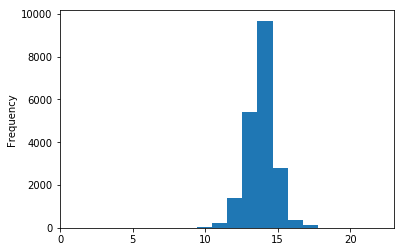

In [23]:
#data['frequency'].plot(kind='hist', bins=50)
data[data['frequency'] > 0]['frequency'].plot(kind='hist', bins=20)
print data[data['frequency'] > 0]['frequency'].describe()

In [24]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 20313 subjects, a: 26884300.27, alpha: 1419971009.79, b: 357669627.04, r: 119932921.12>


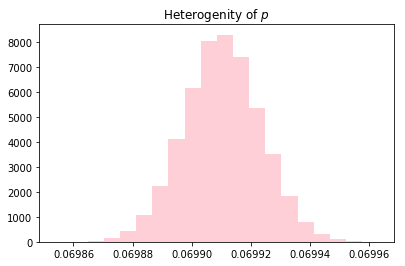

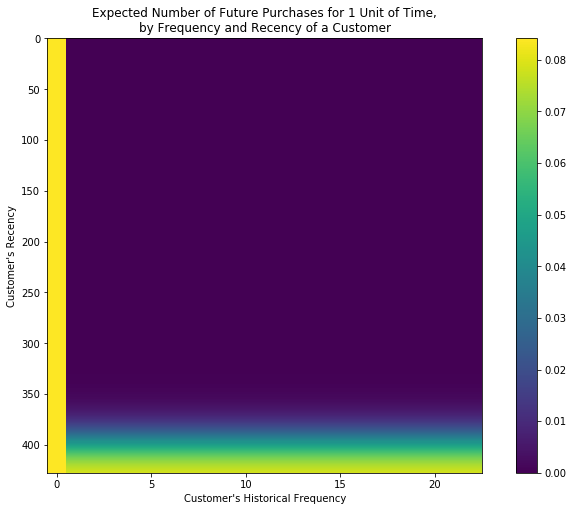

In [25]:
import matplotlib.pyplot as plt
from scipy.stats import beta, gamma, invgamma, norm
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, facecolor='pink', alpha=0.75)
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

In [26]:
#from lifetimes.plotting import plot_probability_alive_matrix
#fig = plt.figure(figsize=(12,8))
#plot_probability_alive_matrix(bgf)
live=bgf.conditional_probability_alive(data['frequency'],
                                  data['recency'],
                                  data['T'])

alive=pd.DataFrame({'CardNum':data.index,'live_prob':live})
alive
alive['CardNum'][2]

545668900.0

In [27]:
t = 30 # days
c=bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                        data['frequency'],
                                                        data['recency'],
                                                        data['T'])
#print(c)


#from lifetimes.plotting import plot_period_transactions
#plot_period_transactions(bgf)

In [30]:



from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CardNo', 'TransacionDate',
                                        calibration_period_end='2017-07-22 ',
                                        observation_period_end='2018-03-12' )   
print(summary_cal_holdout.head())

              frequency_cal  recency_cal  T_cal  frequency_holdout  \
CardNo                                                               
5.456688e+08            7.0        107.0  110.0                5.0   
5.456688e+08           12.0        110.0  118.0                2.0   
5.456689e+08            8.0        111.0  125.0                6.0   
5.456689e+08            8.0         95.0  102.0               13.0   
5.456615e+09            9.0         79.0  116.0                5.0   

              duration_holdout  
CardNo                          
5.456688e+08               233  
5.456688e+08               233  
5.456689e+08               233  
5.456689e+08               233  
5.456615e+09               233  


In [1]:
#from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
#bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
#plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [31]:
t = 10
individual = data.loc[545651023457116]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.9433278018112302e-06

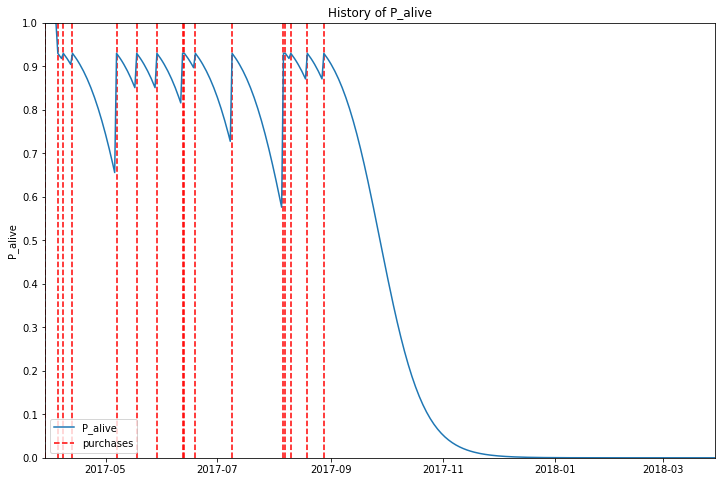

In [32]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 5456667383
days_since_birth = 365
sp_trans = df.loc[df['CardNo'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'TransacionDate')

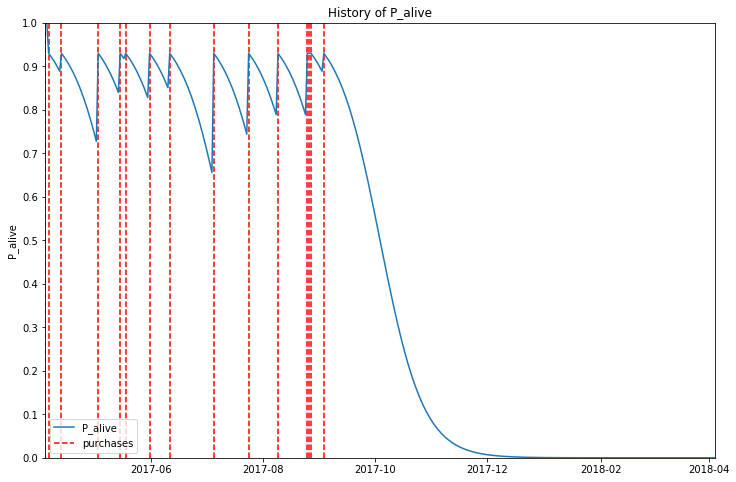

In [33]:
fig = plt.figure(figsize=(12,8))
id = 5456634114
days_since_birth = 365
sp_trans = df.loc[df['CardNo'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'TransacionDate')

In [34]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())


              frequency  recency      T  monetary_value
CardNo                                                 
5.456688e+08       12.0    159.0  343.0       97.072500
5.456688e+08       14.0    161.0  351.0      238.172143
5.456689e+08       14.0    169.0  358.0       72.727143
5.456689e+08       21.0    183.0  335.0       59.570000
5.456615e+09       14.0    167.0  349.0       59.793571


In [35]:
print(len(returning_customers_summary))

20017


In [36]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 20017 subjects, p: 5325.77, q: 6.82, v: 0.11>


In [18]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head())

CardNo
5.456688e+08     97.072672
5.456688e+08    238.163509
5.456689e+08     72.728805
5.456689e+08     59.571654
5.456615e+09     59.796039
dtype: float64


In [37]:
bgf.fit(data['frequency'], data['recency'],data['T'])
print(ggf.customer_lifetime_value(
bgf, #the model to use to predict the number of future transactions
data['frequency'],
data['recency'],
data['T'],
data['monetary_value'],time=12,discount_rate=0.01).head(10))

CardNo
5.456688e+08    0.002882
5.456688e+08    0.004273
5.456689e+08    0.001419
5.456689e+08    0.025970
5.456615e+09    0.002100
5.456615e+09    0.001653
5.456615e+09    0.002890
5.456615e+09    0.000842
5.456615e+09    0.003006
5.456615e+09    0.001907
Name: clv, dtype: float64


In [38]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ret_cust_data = data[data['frequency'] > 0] # only look at customers with repeat purchases
ret_cust_data['monetary_value'] = ret_cust_data['monetary_value']*0.55 # Set Monetary value to gross profit only (see below)
ggf.fit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])
p,q,v = ggf._unload_params('p', 'q', 'v')
print (ggf)

<lifetimes.GammaGammaFitter: fitted with 20017 subjects, p: 5764.63, q: 6.82, v: 0.06>


In [39]:
avg_cond_profit = ggf.conditional_expected_average_profit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])
print "Expected conditional Average profit: %s, Population Average profit %s, Average profit: %s" % (
 avg_cond_profit, 
 (p*v)/(q-1),
 ret_cust_data['monetary_value'].mean()
)

Expected conditional Average profit: CardNo
5.456688e+08      53.389971
5.456688e+08     130.989164
5.456689e+08      40.000977
5.456689e+08      32.764547
5.456615e+09      32.888026
5.456615e+09     127.629299
5.456615e+09      45.256241
5.456615e+09     107.584817
5.456615e+09      39.795528
5.456615e+09      53.767270
5.456615e+09      53.271829
5.456615e+09     111.684149
5.456615e+09      37.485301
5.456615e+09      43.757992
5.456615e+09      35.431638
5.456615e+09      34.080261
5.456615e+09      47.177566
5.456615e+09      55.762105
5.456615e+09      30.574264
5.456615e+09      82.997188
5.456615e+09      40.972016
5.456615e+09      42.201211
5.456615e+09      34.078690
5.456615e+09      54.920432
5.456615e+09      28.905527
5.456615e+09      34.601109
5.456615e+09      40.440056
5.456615e+09      39.144610
5.456615e+09     106.777596
5.456615e+09      45.670030
                   ...     
5.456683e+09     112.080574
5.456683e+09     124.816252
5.456683e+09      54.425651
5.45